## The goal of the notebook is to explore compound screening, one task from the whole drug dicovery process. 

I took the medium post as the basis (https://towardsdatascience.com/drug-discovery-with-deep-learning-under-10-lines-of-codes-742ee306732a) but for deeper understanding I wanted to explore the dataset, choose NN's architecture and write training loop by myself.



## Data samples exploration
Let's look at data formats of molecules, targets and measure reflecting the probability of their connection:

In [1]:
from DeepPurpose import utils, encoders, dataset
import matplotlib.pyplot as plt

X_drugs, X_targets, y = dataset.load_process_DAVIS(path = './data', binary = False, convert_to_log = True, threshold = 30)
print('Drug 1: ' + X_drugs[0])
print('Target 1: ' + X_targets[0])
print('Score 1: ' + str(y[0]))

Beginning Processing...
100% [............................................................................] 179878 / 179878Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!
Drug 1: CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC=C4)N
Target 1: MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELL

In [2]:
from pysmiles import read_smiles
import networkx as nx
    
smiles = 'CN1CCN(CC1)CCCOC2=C(C=C3C(=C2)N=CC(=C3NC4=CC(=C(C=C4Cl)Cl)OC)C#N)OC'
mol = read_smiles(smiles)
    
# atom vector (C only)
print(mol.nodes(data='element'))
# adjacency matrix
print(nx.to_numpy_matrix(mol))


[(0, 'C'), (1, 'N'), (2, 'C'), (3, 'C'), (4, 'N'), (5, 'C'), (6, 'C'), (7, 'C'), (8, 'C'), (9, 'C'), (10, 'O'), (11, 'C'), (12, 'C'), (13, 'C'), (14, 'C'), (15, 'C'), (16, 'C'), (17, 'N'), (18, 'C'), (19, 'C'), (20, 'C'), (21, 'N'), (22, 'C'), (23, 'C'), (24, 'C'), (25, 'C'), (26, 'C'), (27, 'C'), (28, 'Cl'), (29, 'Cl'), (30, 'O'), (31, 'C'), (32, 'C'), (33, 'N'), (34, 'O'), (35, 'C')]
[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


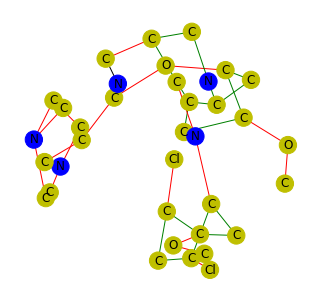

In [3]:
colors = {1: 'red', 2: 'blue', 3: 'black', 4: 'blue', 1.5: 'green', 6: 'blue'}
edge_colors = list(map(lambda x: colors[x], nx.get_edge_attributes(mol,'order').values()))
elements = nx.get_node_attributes(mol, name = "element")
node_colors = list(map(lambda x: 'b' if x == 'N' else 'y', elements.values()))

nx.draw(mol, with_labels=True, labels = elements, pos=nx.spring_layout(mol, k=0.5), edge_color=edge_colors, node_color=node_colors)
plt.gca().set_aspect('equal')

##  Data distribution

The statistics was really helpful for GNN architecture choise and the optiiation of dataset initialization:

- 70% of scores in the dataset are less that 5
- the rest 30% scores distribution looks like normal but its left tain is cut

min 5.0 | max 10.795880017344075
q0.00: 5.00
q0.10: 5.00
q0.20: 5.00
q0.30: 5.00
q0.40: 5.00
q0.50: 5.00
q0.60: 5.00
q0.70: 5.06
q0.80: 5.89
q0.90: 6.74
q1.00: 10.80


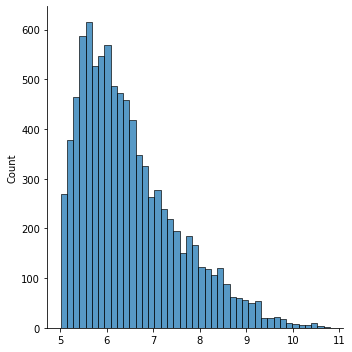

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print(f'min {y.min()} | max {y.max()}')
for i in range(0, 11):
    q = 0.1 * i
    print(f'q{q:.2f}: {np.quantile(y, q):.2f}')

sns.displot(y[y > 5])
plt.show()

* Further we will need to preprocess both, molecules and proteins. Number of unique values much smaller, and there is no need to process them several times.

In [5]:
print(f'Number of samples: {len(X_drugs)}')
print(f'Number of unique molecules: {len(set(X_drugs))}') 
print(f'Number of unique proteins: {len(set(X_targets))}')


Number of samples: 30056
Number of unique molecules: 68
Number of unique proteins: 379


## Dataset 

In this notebook I'm not going to train feature extractor for proteins. 
In order to make the task easier (the data is not big :() pretrained ProSE model was chosen (https://www.cell.com/cell-systems/fulltext/S2405-4712(21)00203-9?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS2405471221002039%3Fshowall%3Dtrue)

Data preprocessing consists of
- the convertion of molecules from SMILES format into heterogeneous graphs (the example is above)
- feature extracion from protein sequences  (the example is bellow)

In [6]:
from prose.models.multitask import ProSEMT
from prose.alphabets import Uniprot21
import torch
from torch.nn import functional as F
from torch_geometric.data import HeteroData, InMemoryDataset, Data
from rdkit import Chem, RDLogger
from DeepPurpose import dataset
import os.path as osp
import sys
from tqdm import tqdm


prot_encoder = ProSEMT.load_pretrained().cuda()

# the function is a modified version of analogous function from prose
def embed_sequence(model, x, pool='none', use_cuda=True):
    if len(x) == 0:
        n = prot_encoder.embedding.proj.weight.size(1)
        z = np.zeros((1,n), dtype=np.float32)
        return z

    alphabet = Uniprot21()
    x = x.upper()
    # convert to alphabet index
    x = alphabet.encode(x)
    x = torch.from_numpy(x)
    if use_cuda:
        x = x.cuda()

    # embed the sequence
    with torch.no_grad():
        x = x.long().unsqueeze(0)
        z = prot_encoder(x)
        # pool if needed
        z = z.squeeze(0)
        if pool == 'sum':
            z = z.sum(0)
        elif pool == 'max':
            z,_ = z.max(0)
        elif pool == 'avg':
            z = z.mean(0)
        z = z.cpu().numpy()

    return torch.tensor(z[-1]).unsqueeze(0)


In [7]:
prot = 'MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQKPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL'
x = embed_sequence(prot_encoder, bytes(prot, 'UTF-8'))
print(x)
print(x.shape)

tensor([[ 1.4221e-01,  1.0605e-04, -1.0202e+00,  2.3216e-01,  2.7127e+00,
          1.5553e+00,  5.2568e-02,  6.5255e-01,  2.2017e+00,  1.8898e+00,
         -1.0489e+00, -1.4829e+00, -1.4568e+00,  6.2028e-01,  1.1161e+00,
         -2.5076e+00,  1.6985e+00,  7.9740e-01, -2.9543e-01,  3.8746e-01,
         -2.0498e+00, -1.4630e+00,  4.0246e-01, -5.9976e-01,  2.6451e-01,
          2.8399e-01,  1.3207e+00,  9.4898e-01, -1.4305e+00,  1.9663e+00,
          2.4774e-01,  2.9671e-01, -1.9901e+00,  1.5563e+00, -7.5265e-03,
          2.1099e-01,  1.2849e+00,  1.1547e+00, -2.1860e+00, -2.2269e+00,
         -6.8451e-01, -8.4885e-01, -1.1150e-01,  4.0286e-01,  8.7248e-01,
          3.7417e-01, -1.2126e+00,  1.6518e+00, -1.6030e+00, -3.5189e-01,
         -5.2931e-01,  2.5432e+00, -4.7515e-01,  7.2074e-01,  2.0420e+00,
          3.2496e-01, -1.1756e+00,  1.7531e+00,  1.7580e+00, -2.0580e+00,
         -1.8210e+00, -1.1097e+00,  1.3318e+00,  9.3648e-01,  8.3479e-01,
         -1.1243e+00,  7.2118e-01,  1.

Could not load symbol cublasGetSmCountTarget from libcublas.so.11. Error: /usr/local/cuda-11.2/lib64/libcublas.so.11: undefined symbol: cublasGetSmCountTarget


In [8]:
# the cell code is taken from pytorch geometric since only the latest version contains it but the version is not released yet

x_map = {
    'atomic_num':
    list(range(0, 119)),
    'chirality': [
        'CHI_UNSPECIFIED',
        'CHI_TETRAHEDRAL_CW',
        'CHI_TETRAHEDRAL_CCW',
        'CHI_OTHER',
    ],
    'degree':
    list(range(0, 11)),
    'formal_charge':
    list(range(-5, 7)),
    'num_hs':
    list(range(0, 9)),
    'num_radical_electrons':
    list(range(0, 5)),
    'hybridization': [
        'UNSPECIFIED',
        'S',
        'SP',
        'SP2',
        'SP3',
        'SP3D',
        'SP3D2',
        'OTHER',
    ],
    'is_aromatic': [False, True],
    'is_in_ring': [False, True],
}

e_map = {
    'bond_type': [
        'misc',
        'SINGLE',
        'DOUBLE',
        'TRIPLE',
        'AROMATIC',
    ],
    'stereo': [
        'STEREONONE',
        'STEREOZ',
        'STEREOE',
        'STEREOCIS',
        'STEREOTRANS',
        'STEREOANY',
    ],
    'is_conjugated': [False, True],
}

    
def smiles2graph(smiles: str, 
                 with_hydrogen: bool = False,
                 kekulize: bool = False):

    RDLogger.DisableLog('rdApp.*')

    mol = Chem.MolFromSmiles(smiles)

    if mol is None:
        mol = Chem.MolFromSmiles('')
    if with_hydrogen:
        mol = Chem.AddHs(mol)
    if kekulize:
        mol = Chem.Kekulize(mol)

    xs = []
    for atom in mol.GetAtoms():            
        x = []
        x.append(F.one_hot(torch.tensor(x_map['atomic_num'].index(atom.GetAtomicNum())), 
                           num_classes=len(x_map['atomic_num'])))
        x.append(F.one_hot(torch.tensor(x_map['chirality'].index(str(atom.GetChiralTag()))),
                           num_classes=len(x_map['chirality'])))
        x.append(F.one_hot(torch.tensor(x_map['degree'].index(atom.GetTotalDegree())), 
                           num_classes=len(x_map['degree'])))
        x.append(F.one_hot(torch.tensor(x_map['formal_charge'].index(atom.GetFormalCharge())), 
                           num_classes=len(x_map['formal_charge'])))
        x.append(F.one_hot(torch.tensor(x_map['num_hs'].index(atom.GetTotalNumHs())), 
                           num_classes=len(x_map['num_hs'])))
        x.append(F.one_hot(torch.tensor(x_map['num_radical_electrons'].index(atom.GetNumRadicalElectrons())), 
                           num_classes=len(x_map['num_radical_electrons'])))
        x.append(F.one_hot(torch.tensor(x_map['hybridization'].index(str(atom.GetHybridization()))), 
                           num_classes=len(x_map['hybridization'])))
        x.append(F.one_hot(torch.tensor(x_map['is_aromatic'].index(atom.GetIsAromatic())), 
                           num_classes=len(x_map['is_aromatic'])))
        x.append(F.one_hot(torch.tensor(x_map['is_in_ring'].index(atom.IsInRing())), 
                           num_classes=len(x_map['is_in_ring'])))
        xs.append(torch.cat(x))

    xs = torch.stack(xs, dim=0).float()
    edge_indices, edge_attrs = [], []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        e = []
        e.append(e_map['bond_type'].index(str(bond.GetBondType())))
        e.append(e_map['stereo'].index(str(bond.GetStereo())))
        e.append(e_map['is_conjugated'].index(bond.GetIsConjugated()))

        edge_indices += [[i, j], [j, i]]
        edge_attrs += [e, e]

    edge_index = torch.tensor(edge_indices)
    edge_index = edge_index.t().to(torch.long).view(2, -1)
    edge_attr = torch.tensor(edge_attrs, dtype=torch.long).view(-1, 3)

    if edge_index.numel() > 0:  # Sort indices.
        perm = (edge_index[0] * xs.size(0) + edge_index[1]).argsort()
        edge_index, edge_attr = edge_index[:, perm], edge_attr[perm]
    
    return (xs, edge_index, edge_attr)


def generate_sample(mol_data, prot_data, score):
    x, edge_index, edge_attr = mol_data[1]
    prot, prot_emb = prot_data
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, protein=prot, prot_emb=prot_emb, score=score)

In [9]:
import numpy as np
from random import sample

# split data
data_size = len(X_targets)
train_indices = list(filter(lambda x: x % 10 != 0, range(data_size)))
val_indices = list(filter(lambda x: x % 10 == 0, range(data_size)))

# preprocess uniq molecues and proteins
encoded_proteins = dict(map(lambda x: (x, 
                                       embed_sequence(prot_encoder, bytes(x, 'UTF-8'))), set(X_targets)))
molecules = dict(map(lambda x: (x, smiles2graph(x)), set(X_drugs)))


class MyOwnDataset(InMemoryDataset):
    def __init__(self, root='./data', pre_transform=generate_sample, indices=[], transform=None, pre_filter=None):
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data, self.slices = self.preprocess(indices)

    def preprocess(self, indices):
        
        data_list = []

        if self.pre_transform is not None:
            data_list = [self.pre_transform((X_drugs[i], molecules[X_drugs[i]]),
                                            (X_targets[i], encoded_proteins[X_targets[i]]), 
                                             y[i]) 
                                            for i in indices]
        data, slices = self.collate(data_list)
        return data, slices

#         torch.save((data, slices), self.processed_paths[0])
        

## Model

Basic GNN is modified in the following way:

- it inputs nodes features, edge indices and proteins embeddings;
- it extracts features from molecule graph, concatenates it with proteins embeddings and pass to MLP to get a single score prediction for each sample in a batch

In [10]:
import torch_geometric.transforms as T
from torch_geometric.datasets import OGB_MAG
from torch_geometric.nn import SAGEConv, to_hetero
from torch_geometric.nn import global_max_pool
from torch_geometric.loader import DataLoader
from torch.nn import MSELoss, Linear, MaxPool1d
from torch.optim import SGD
import torch.nn as nn


class GNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        self.features = nn.Sequential(nn.Linear(172, 128), nn.BatchNorm1d(128), nn.PReLU(),
                                     nn.Linear(128, 64), nn.BatchNorm1d(64), nn.PReLU(),
                                     nn.Linear(64, 32), nn.BatchNorm1d(32), nn.PReLU())
        self.conv1 = SAGEConv((-1, -1), hidden_channels)
        self.conv2 = SAGEConv((-1, -1), out_channels)
        self.lin = Linear(100, 32)
        self.merge = nn.Sequential(nn.Linear(64, 64), nn.BatchNorm1d(64), nn.PReLU(),
                                     nn.Linear(64, 32), nn.BatchNorm1d(32), nn.PReLU(),
                                     nn.Linear(32, 1), nn.BatchNorm1d(1), nn.ReLU())
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.01)
        
    def forward(self, x, edge_index, prot_emb, batch):
        x = self.features(x)
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        x = global_max_pool(x, batch)

        x1 = self.lin(prot_emb)
        x = self.merge(torch.cat([x, x1], dim=1)) 

        return x + 5


## Train loop 

In [18]:
# batch_size = 64
# train_dataset = MyOwnDataset(indices=train_indices)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_dataset = MyOwnDataset(indices=val_indices)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = GNN(32, 32).cuda()
optimizer = SGD(model.parameters(), lr=0.1)
criterion = MSELoss(reduction='none') 


In [12]:
def train(train_loader, criterion, optimizer):
    model.train()
    total_examples = total_loss = 0
    for data in train_loader:
        optimizer.zero_grad()
        data = data.to('cuda:0')
        y = data.score.float()
        out = model(x=data.x.float(), edge_index=data.edge_index, prot_emb=data.prot_emb, batch=data.batch)#, batch.compound.edge_attribute_dict)
        loss = criterion(out.squeeze(1), y) 
        # the trick is required sicnce data ismbalanced
        loss[y < 5.01] *= 0.1
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

def val(val_loader, criterion):
    model.eval()
    total_examples = total_loss = 0
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to('cuda:0')
            y = data.score.float()
            out = model(x=data.x.float(), edge_index=data.edge_index, prot_emb=data.prot_emb, batch=data.batch)#, batch.compound.edge_attribute_dict)
            loss = criterion(out.squeeze(1), y) 
            loss = loss.mean()

            total_examples += batch_size
            total_loss += float(loss) * batch_size
            
    return total_loss / total_examples


## Results
Remember that scores are not normalized and ranged from 5 for 10.8. 
The lowest error of 0.6 on val set is quite good but it does not differ much from the first epoch. The loss value is good even on the first epoch (probably, because of pretrained encoder).

In [17]:
val_loss = val(val_loader, criterion)
print(f'Before Train Loss: {val_loss:.2f}')
for i in range(10):
    train_loss = train(train_loader, criterion, optimizer)
    val_loss = val(val_loader, criterion)
    print(f'Epoch: {i} | Train Loss: {train_loss:.2f} | Val Loss: {val_loss:.2f}')

Before Train Loss: 0.78
Epoch: 0 | Train Loss: 0.46 | Val Loss: 0.99
Epoch: 1 | Train Loss: 0.39 | Val Loss: 0.88
Epoch: 2 | Train Loss: 0.36 | Val Loss: 0.72
Epoch: 3 | Train Loss: 0.35 | Val Loss: 0.71
Epoch: 4 | Train Loss: 0.33 | Val Loss: 0.82
Epoch: 5 | Train Loss: 0.32 | Val Loss: 0.81
Epoch: 6 | Train Loss: 0.31 | Val Loss: 0.60
Epoch: 7 | Train Loss: 0.30 | Val Loss: 0.68
Epoch: 8 | Train Loss: 0.29 | Val Loss: 0.60
Epoch: 9 | Train Loss: 0.28 | Val Loss: 0.65


In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchtext.vocab import vocab
from torchtext.transforms import VocabTransform
from collections import OrderedDict
from DeepPurpose import utils, encoders, dataset
from torchtext.functional import to_tensor


class SmilesDataset(Dataset):
    def __init__(self, mode='train', indices=None):
        super().__init__()
        self.X_drugs, self.X_targets, self.y = dataset.load_process_DAVIS(path = './data', binary = False, convert_to_log = True, threshold = 30)
        drugs_symb_set = list(set(''.join(self.X_drugs.tolist())))
        #targets_symb_set = list(set(''.join(self.X_targets.tolist())))
        drugs_vocab_obj = vocab(OrderedDict([(drugs_symb_set[i], i + 1) for i in range(len(drugs_symb_set))]))
        #targets_vocab_obj = vocab(OrderedDict([(targets_symb_set[i], i + 1) for i in range(len(targets_symb_set))]))
        self.drugs_vocab_transform = VocabTransform(drugs_vocab_obj)
        #self.targets_vocab_transform = VocabTransform(targets_vocab_obj)
        self.encoded_proteins = dict(map(lambda x: (x, 
                                       embed_sequence(prot_encoder, bytes(x, 'UTF-8'))), set(self.X_targets)))
        
        self.X_drugs = self.X_drugs[indices]
        self.X_targets = self.X_targets[indices]
        self.y = self.y[indices]
        
    def __getitem__(self, idx):
        
        drug0 = self.X_drugs[idx]
        target = self.X_targets[idx]
        y = self.y[idx]

        drug = self.drugs_vocab_transform(list(drug0))
        #print(drug)
#         drug_embedding = to_tensor(drug, padding_value=0)#.unsqueeze(0)
        #drug_embedding = torch.nn.functional.one_hot(torch.LongTensor(drug)) 
        
        target_embedding = self.encoded_proteins[target].squeeze(1)
#         print(1111, drug_embedding.shape, drug0)
        return drug, target_embedding, y
        
    def __len__(self):
        
        return len(self.X_drugs)
    
    def collate_fn(self, batch):
        
        drugs = []
        proteins = []
        labels = []
        for drug, target_embedding, y in batch:
            drugs.append(drug)
            proteins.append(target_embedding)
            labels.append(y)
            
        drugs = to_tensor(drugs, padding_value=0)
        proteins = torch.cat(proteins)
        labels = torch.FloatTensor(labels)
        
        return drugs, proteins, labels


In [21]:
from torch.nn import MSELoss, Linear, MaxPool1d, AdaptiveAvgPool1d#AvgPool1d
from torch.optim import SGD
import torch.nn as nn

from torchtext.models import RobertaEncoderConf, RobertaBundle, RobertaClassificationHead

# symb_set = list(set(''.join(X_drugs.tolist())))


class SmilesModels(torch.nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        encoder_conf = RobertaEncoderConf(vocab_size=vocab_size)
        self.drug_encoder = RobertaBundle.build_model(encoder_conf=encoder_conf, head=None)
        self.pool = AdaptiveAvgPool1d(1)
        self.lin_proj_drug = Linear(768, 32)
        self.lin_proj_prot = Linear(100, 32)
        self.merge = nn.Sequential(nn.Linear(64, 64), nn.BatchNorm1d(64), nn.PReLU(),
                                     nn.Linear(64, 32), nn.BatchNorm1d(32), nn.PReLU(),
                                     nn.Linear(32, 1), nn.BatchNorm1d(1), nn.ReLU())
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0.01)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0.01)
        
    def forward(self, drug_inp, prot_emb):
#         print(drug_inp.shape, drug_inp.device)
        x = self.drug_encoder(drug_inp).transpose(2, 1)
#         print(x.shape)
        x = x.mean(-1)
#         x = self.pool(x).squeeze(-1)
        x = self.lin_proj_drug(x)
#         print(prot_emb.shape)
        x1 = self.lin_proj_prot(prot_emb).squeeze(1)
#         print(1111, x.shape, x1.shape)
        x = self.merge(torch.cat([x, x1], dim=1)) 

        return x + 5



In [23]:
from random import sample

train_dataset = SmilesDataset(mode='train', indices=train_indices)
val_dataset = SmilesDataset(mode='val', indices=val_indices)

Beginning Processing...
100% [............................................................................] 179878 / 179878Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!
Beginning Processing...
100% [............................................................................] 179878 / 179878Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!


In [24]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

vocab_size = len(set(''.join(X_drugs.tolist())))
model = SmilesModels(vocab_size=vocab_size)
model.cuda()
optimizer = SGD(model.parameters(), lr=0.01)
criterion = MSELoss(reduction='none') 

In [25]:
def train(train_loader, criterion, optimizer):
    model.train()
    total_examples = total_loss = 0
    for drug_embedding, target_embedding, y in train_loader:
        optimizer.zero_grad()
        drug_embedding = drug_embedding.cuda()
        target_embedding = target_embedding.cuda()
        y = y.cuda()
        out = model(drug_embedding, target_embedding)#, batch.compound.edge_attribute_dict)
        loss = criterion(out.squeeze(1), y) 
        # the trick is required sicnce data ismbalanced
        loss[y < 5.01] *= 0.1
        loss = loss.mean()
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    return total_loss / total_examples

def val(val_loader, criterion):
    model.eval()
    total_examples = total_loss = 0
    
    with torch.no_grad():
        for drug_embedding, target_embedding, y in val_loader:
            drug_embedding = drug_embedding.cuda()
            target_embedding = target_embedding.cuda()
            y = y.cuda()
            out = model(drug_embedding, target_embedding)
            loss = criterion(out.squeeze(1), y) 
            loss = loss.mean()

            total_examples += batch_size
            total_loss += float(loss) * batch_size
            
    return total_loss / total_examples



In [26]:
val_loss = val(val_loader, criterion)
print(f'Before Train Loss: {val_loss:.2f}')
for i in range(10):
    train_loss = train(train_loader, criterion, optimizer)
    val_loss = val(val_loader, criterion)
    print(f'Epoch: {i} | Train Loss: {train_loss:.2f} | Val Loss: {val_loss:.2f}')

Before Train Loss: 1.10
Epoch: 0 | Train Loss: 0.46 | Val Loss: 1.90
Epoch: 1 | Train Loss: 0.38 | Val Loss: 1.11
Epoch: 2 | Train Loss: 0.36 | Val Loss: 0.86
Epoch: 3 | Train Loss: 0.35 | Val Loss: 1.20
Epoch: 4 | Train Loss: 0.35 | Val Loss: 1.20
Epoch: 5 | Train Loss: 0.34 | Val Loss: 1.39
Epoch: 6 | Train Loss: 0.34 | Val Loss: 1.05
Epoch: 7 | Train Loss: 0.33 | Val Loss: 0.92
Epoch: 8 | Train Loss: 0.33 | Val Loss: 1.01
Epoch: 9 | Train Loss: 0.33 | Val Loss: 0.88


# Conclusion

Graph representation metric:  MSE=0.6
SMILES representation metric: MSE=0.86